In [1]:
import os
import math
import random
import pandas as pd
import numpy as np
import seaborn as sns
import autosklearn.regression as autoreg
from autosklearn.experimental.askl2 import AutoSklearn2Classifier
from autosklearn.metrics import make_scorer
from sklearn.model_selection import TimeSeriesSplit
from pandas import datetime
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from functions import *


/home/charles/anaconda3/envs/autosk07/lib/python3.7/site-packages/pyparsing.py:3190: FutureWarning: Possible set intersection at position 3
  self.re = re.compile(self.reString)


In [23]:
from sklearn.model_selection import BaseCrossValidator
class BlockingTimeSeriesSplit(BaseCrossValidator):
    def __init__(self, n_splits):
        self.n_splits = n_splits
    
    def get_n_splits(self, X, y, groups):
        return self.n_splits
    
    def split(self, X, y=None, groups=None):
        n_samples = len(X)
        k_fold_size = n_samples // self.n_splits
        indices = np.arange(n_samples)

        margin = 0
        for i in range(self.n_splits):
            start = i * k_fold_size
            stop = start + k_fold_size
            mid = int(0.8 * (stop - start)) + start
            yield indices[start: mid], indices[mid + margin: stop]

In [ ]:
def quantile_loss(solution, prediction, quantile):
    e = solution - prediction
    return np.mean(np.maximum(e*quantile, e*(quantile - 1)))

qloss_05= make_scorer(
        name="quantile_loss_05",
        score_func=quantile_loss,
        optimum=1,
        greater_is_better=False,
        needs_proba=False,
        needs_threshold=False,
        quantile=0.05,
    )
qloss_95= make_scorer(
        name="quantile_loss_95",
        score_func=quantile_loss,
        optimum=1,
        greater_is_better=False,
        needs_proba=False,
        needs_threshold=False,
        quantile=0.95,
    )

qloss_10= make_scorer(
        name="quantile_loss_10",
        score_func=quantile_loss,
        optimum=1,
        greater_is_better=False,
        needs_proba=False,
        needs_threshold=False,
        quantile=0.10,
    )

qloss_90= make_scorer(
        name="quantile_loss_90",
        score_func=quantile_loss,
        optimum=1,
        greater_is_better=False,
        needs_proba=False,
        needs_threshold=False,
        quantile=0.90,
    )
qloss_025= make_scorer(
        name="quantile_loss_025",
        score_func=quantile_loss,
        optimum=1,
        greater_is_better=False,
        needs_proba=False,
        needs_threshold=False,
        quantile=0.025,
    )

qloss_975= make_scorer(
        name="quantile_loss_975",
        score_func=quantile_loss,
        optimum=1,
        greater_is_better=True,
        needs_proba=False,
        needs_threshold=False,
        quantile=0.975,
    )
qloss_5 = make_scorer(
        name="quantile_loss_5",
        score_func=quantile_loss,
        optimum=1,
        greater_is_better=True,
        needs_proba=False,
        needs_threshold=False,
        quantile=0.5,
    )

In [2]:
train = pd.read_csv("../data/train_solar.csv", index_col = 'timestamp')
test = pd.read_csv("../data/test_solar.csv", index_col = 'timestamp')

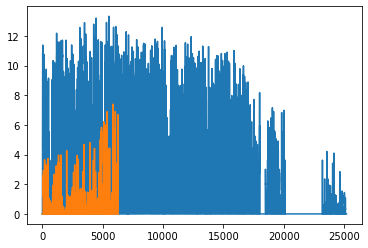

In [10]:
plt.plot(train.energy.to_numpy())
plt.plot(test.energy.to_numpy())

In [25]:
from tsfresh.feature_extraction.feature_calculators import agg_autocorrelation
agg_autocorrelation(train.energy, param=[{"f_agg":'mean', 
                                         "maxlag":300}])

[('f_agg_"mean"__maxlag_300', 0.12146818748667855)]

In [3]:
train = extract_dmhq(train)
test = extract_dmhq(test)

In [17]:
from sklearn.model_selection import train_test_split
## Shuffle by every two days
data = pd.concat([train, test],axis = 0)
data = extract_dmhq(data)
cols = ['yd']
ftrain, ttrain = feature_target_construct(data, 'energy', 200, 192, 0, 1, cols, 4,
                                          wd_on = False, d_on = False,
                                          m_on = False, h_on = False, q_on = False)
data = pd.concat([ftrain, ttrain], axis = 1)

# now define random split groups
groups = [data for _, data in data.groupby('yd1(t+0)')]
random.shuffle(groups,)

for i, df in enumerate(groups):
    data['yd1(t+0)'] = i+1
shuffled = pd.concat(groups).reset_index(drop=True)
ftrain = shuffled.iloc[:,1:201]
ttrain = shuffled.iloc[:,201:]

## split in 7/3 manner
train_X, test_X, train_Y, test_Y = train_test_split(ftrain, ttrain, train_size = 0.7, shuffle = False)

In [7]:
cols = ['cloudCover','uvIndex']
ftrain, ttrain = feature_target_construct(train, 'energy', 200, 192, 0, 1, cols, 4,
                                          wd_on = False, d_on = False,
                                          m_on = False, h_on = False, q_on = False)

ftest, ttest = feature_target_construct(test, 'energy', 200, 192, 0, 1, cols, 4, 
                                        wd_on = False, d_on = False,
                                        m_on = False, h_on = False, q_on = False)

In [18]:
from sklearn.linear_model import Ridge
rr = Ridge(alpha=10000)
rr.fit(ftrain, ttrain)
ypred = rr.predict(ftest)
yhat = rr.predict(ftrain)

In [6]:
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
etr = RandomForestRegressor(n_jobs=3, bootstrap=True, warm_start = True)
etr.fit(ftrain, ttrain)
ypred = etr.predict(ftest)
yhat = etr.predict(ftrain)

In [19]:
get_eval(ttrain, yhat)
get_eval(ttest, ypred)

MSE: 2.4511249482112514
MAE: 0.8838524104818203
r2_score: 0.69171781862523
MSE: 0.49736038143063094
MAE: 0.37839468044687097
r2_score: 0.3758864150837292


In [116]:
get_eval(ttrain, yhat)
get_eval(ttest, ypred)

MSE: 2.556127100034985
MAE: 0.912709083963818
r2_score: 0.6774605416186056
MSE: 0.5364453795046394
MAE: 0.4269374202416481
r2_score: 0.3189546438393651


In [54]:
# pacf_val, conf = pacf(train.energy, nlags = 700, alpha = 0.05)
# indices = np.argwhere((np.abs(pacf_val) > 0.025))

NameError: name 'plot_pacf' is not defined

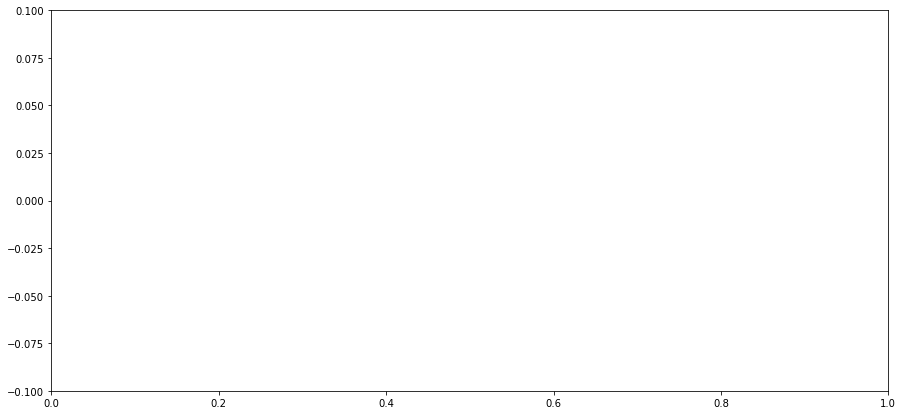

In [24]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (15,7))
plt.ylim(-0.1,0.1)
plot_pacf(train.energy, lags = 500, ax = ax)

### tsFresh featuer construction

In [2]:
train = pd.read_csv("../data/train_solar.csv", )
test = pd.read_csv("../data/test_solar.csv", )
ftrain, ttrain = tf_construct(train, 'energy', 200, 192)
ftest, ttest = tf_construct(test, 'energy', 200, 192)

In [18]:
from tsfresh.utilities.dataframe_functions import make_forecasting_frame
from tsfresh import extract_features

# ftrain_tf = pd.DataFrame()
# for i in range(5000):
#     df_time, y = make_forecasting_frame(ftrain.iloc[i,:].to_numpy(), kind = 'time', max_timeshift=300, rolling_direction=1)
#     df_time.drop(['time','kind'],axis = 1, inplace = True)
#     df_time = df_time.loc[df_time['id'] == 'id=id,timeshift=299']
#     extracted_features = extract_features(df_time, column_id='id').dropna(axis = 1)
#     ftrain_tf = ftrain_tf.append(extracted_features)

ftest_tf = pd.DataFrame()
for i in range(ftest.shape[0]):
    df_time, y = make_forecasting_frame(ftest.iloc[i,:].to_numpy(), kind = 'time', max_timeshift=300, rolling_direction=1)
    df_time.drop(['time','kind'],axis = 1, inplace = True)
    df_time = df_time.loc[df_time['id'] == 'id=id,timeshift=299']
    extracted_features = extract_features(df_time, column_id='id').dropna(axis = 1)
    ftest_tf = ftest_tf.append(extracted_features)

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  6.65it/s]


Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  6.44it/s]


Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  6.05it/s]


Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  6.85it/s]


In [20]:
ftrain_tf.to_csv("tftrain_solar300_n5000.csv", index= 'id')
ftest_tf.to_csv("tftest_solar300_p1000.csv", index= 'id')
ftrain_tf.shape, ftest_tf.shape

((4509, 758), (509, 758))

# Train:3000, test:500 (384)

In [3]:
ftrain_tf = pd.read_csv('tftrain_solar300_n5000.csv', index_col='id')
ftest_tf = pd.read_csv('tftest_solar300_p1000.csv', index_col='id')

## Tsfresh Feature

In [7]:
from sklearn.datasets import load_diabetes
ldata = load_diabetes()
X = ldata.data
Y = ldata.target

In [8]:
X.shape, Y.shape


((442, 10), (442,))

In [3]:
from sklearn.model_selection import TimeSeriesSplit

reg_tf = autoreg.AutoSklearnRegressor(time_left_for_this_task=300,
                                           per_run_time_limit=100,
                                           initial_configurations_via_metalearning=0,
                                           ensemble_size=50, 
                                           ensemble_nbest=20,
                                           ensemble_memory_limit=5120, 
                                           seed=123, ml_memory_limit=6144, 
                                           include_estimators=None,
                                           exclude_estimators=None, 
                                           include_preprocessors=None, 
                                           exclude_preprocessors=None, 
                                           resampling_strategy='holdout',
#                                           resampling_strategy_arguments={'folds':5},
                                           tmp_folder=None, 
                                           output_folder=None,
                                           delete_tmp_folder_after_terminate=False, 
                                           delete_output_folder_after_terminate=False, 
                                           shared_mode=False, 
                                           n_jobs = 6, 
                                           disable_evaluator_output=False, 
                                           get_smac_object_callback=None, 
                                           smac_scenario_args=None, 
                                           logging_config=None,
                                           metadata_directory=None)


reg_tf.fit(X, Y)

[WARNING] [2020-07-14 12:54:12,756:smac.runhistory.runhistory.RunHistory] Encountered exception Expecting ',' delimiter: line 1224 column 1276 (char 86614) while reading runhistory from /tmp/autosklearn_tmp_ab07e214-c5bf-11ea-a55b-19c14d88d1e3/smac3-output/run_3722177746/runhistory.json. Not adding any runs!


/home/charles/anaconda3/envs/autosk07/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


AutoSklearnRegressor(delete_output_folder_after_terminate=False,
                     delete_tmp_folder_after_terminate=False,
                     disable_evaluator_output=False, ensemble_memory_limit=5120,
                     ensemble_nbest=20, ensemble_size=50,
                     exclude_estimators=None, exclude_preprocessors=None,
                     get_smac_object_callback=None, include_estimators=None,
                     include_preprocessors=None,
                     initial_configurations_via_metalearning=0,
                     logging_config=None, max_models_on_disc=50,
                     metadata_directory=None, metric=None, ml_memory_limit=6144,
                     n_jobs=6, output_folder=None, per_run_time_limit=100,
                     resampling_strategy='holdout',
                     resampling_strategy_arguments=None, seed=123,
                     shared_mode=False, smac_scenario_args=None,
                     time_left_for_this_task=300, tmp_folder=None

In [4]:
reg_tf.cv_results_

{'mean_test_score': array([  0.        ,  -0.54433127,  -1.24104785,  -0.09887468,
         -0.52743447,  -0.53437705,  -0.52275845,  -0.5209111 ,
         -0.49431656,   0.        ,   0.        ,  -0.54433127,
          0.        ,  -0.21273305,  -0.52132784,   0.        ,
          0.        ,  -0.53427398,  -0.54433127,  -0.35746065,
         -0.49464094,   0.        ,   0.        ,  -0.57642399,
         -0.79894038,   0.        ,   0.        ,  -0.45666207,
          0.        ,   0.        ,  -0.54012977,  -0.50128339,
          0.        ,  -0.54352875,   0.        ,   0.        ,
         -1.8786891 ,   0.        ,   0.        ,   0.        ,
         -3.7725321 ,   0.        ,   0.        ,  -0.51001161,
         -0.54433127,   0.        ,   0.        ,  -0.54433127,
          0.        ,  -0.65756299,   0.        ,   0.        ,
          0.        ,  -2.19906358,  -0.54433127,  -0.53347609,
          0.        ,  -2.8591011 ,  -0.43516198,   0.        ,
          0.        ,

In [5]:
print(reg_tf.get_models_with_weights())
print(reg_tf.sprint_statistics())

[(0.2, SimpleRegressionPipeline({'data_preprocessing:categorical_transformer:categorical_encoding:__choice__': 'one_hot_encoding', 'data_preprocessing:categorical_transformer:category_coalescence:__choice__': 'minority_coalescer', 'data_preprocessing:numerical_transformer:imputation:strategy': 'mean', 'data_preprocessing:numerical_transformer:rescaling:__choice__': 'normalize', 'feature_preprocessor:__choice__': 'pca', 'regressor:__choice__': 'decision_tree', 'data_preprocessing:categorical_transformer:category_coalescence:minority_coalescer:minimum_fraction': 0.15106317403639516, 'feature_preprocessor:pca:keep_variance': 0.5660771291590012, 'feature_preprocessor:pca:whiten': 'True', 'regressor:decision_tree:criterion': 'mae', 'regressor:decision_tree:max_depth_factor': 0.6095050686448309, 'regressor:decision_tree:max_features': 1.0, 'regressor:decision_tree:max_leaf_nodes': 'None', 'regressor:decision_tree:min_impurity_decrease': 0.0, 'regressor:decision_tree:min_samples_leaf': 4, 're

In [32]:
reg_tf.refit(ftrain_tf, ttrain)

/home/charles/anaconda3/envs/autoskdev/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


AutoSklearnRegressor(delete_output_folder_after_terminate=False,
                     delete_tmp_folder_after_terminate=False,
                     disable_evaluator_output=False, ensemble_memory_limit=5120,
                     ensemble_nbest=20, ensemble_size=50,
                     exclude_estimators=None, exclude_preprocessors=None,
                     get_smac_object_callback=None, include_estimators=None,
                     include_preprocessors=None,
                     initial_configuration...
                     logging_config=None, max_models_on_disc=50,
                     metadata_directory=None, metric=None, ml_memory_limit=6144,
                     n_jobs=6, output_folder='out5313', per_run_time_limit=600,
                     resampling_strategy=<class 'sklearn.model_selection._split.TimeSeriesSplit'>,
                     resampling_strategy_arguments={'folds': 5}, seed=123,
                     shared_mode=False, smac_scenario_args=None,
                     ti

In [33]:
ypred_tf = reg_tf.predict(ftest_tf)
yhat_tf = reg_tf.predict(ftrain_tf)
get_eval(ttest, ypred_tf)
get_eval(ttrain, yhat_tf)

MSE: 551796.6778278005
MAE: 283.93971994401556
r2_score: 0.39711524788214864
MSE: 285767.04502082994
MAE: 240.56785462065895
r2_score: 0.5476141499744366


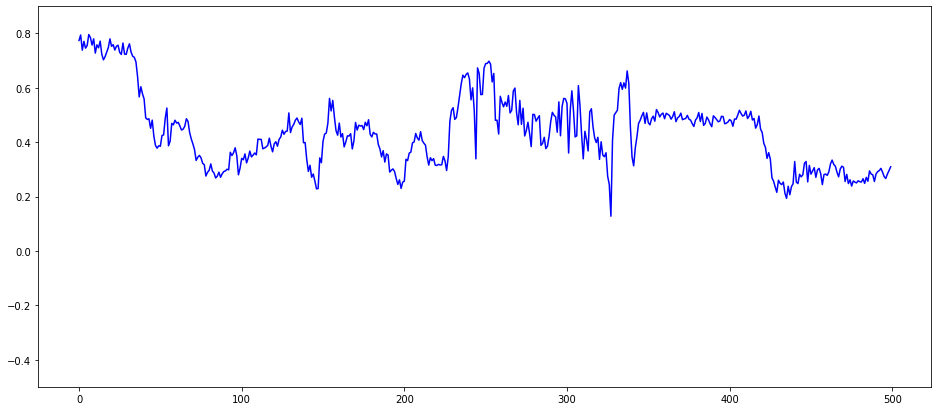

In [34]:
from sklearn.metrics import r2_score

r2tf_list_test = []
for i in range(500):
    o_y = np.transpose(ttest.iloc[i,:].to_numpy().reshape(1,-1))
    p_y = np.transpose(ypred_tf[i,:].reshape(1,-1))
    r2 = r2_score(o_y, p_y)
    r2tf_list_test.append(r2)
fig = plt.figure(figsize = (16, 7))
plt.ylim(-0.5,0.9)
plt.plot(r2tf_list_test, 'b-')

**Confidecne interval**

**random sampling**

In [ ]:
from sklearn.utils import resample
n_bootstraps = 50
b_x = []
b_y = []
for _ in range(n_bootstraps):
    sample_X, sample_y = resample(ftrain_tf, ttrain, n_samples = 2500)
    b_x.append(sample_X)
    b_y.append(sample_y)

In [ ]:
prediction = []

for i, feature in enumerate(b_x):
    reg_tf.refit(feature, b_y[i])
    prediction.append(reg_tf.predict(ftest_tf))

In [ ]:
get_eval(ttest, np.quantile(prediction, 0.5, axis = 0))

In [ ]:
fig = plt.figure(figsize = (15,7))
plt.plot(np.quantile(prediction, 0.9, axis = 0)[0,:], 'g--')
plt.plot(np.quantile(prediction, 0.1, axis = 0)[0,:], 'g--')
plt.plot(np.quantile(prediction, 0.5, axis = 0)[0,:], 'b-')
plt.plot(ttest.to_numpy()[0,:], 'ro')

### fix time frame randomized rolling sampling- should change to backtesting later**

In [ ]:
from sklearn.model_selection import RepeatedKFold, KFold
n_bootstraps = 50
b_x = []
b_y = []
kfcv = KFold(n_splits = 3, random_state = None)
for train_idx, test_idx in kfcv.split(ftrain_tf):
    print(len(train_idx))
# for _ in range(n_bootstraps):
    sample_X, sample_y = ftrain_tf.to_numpy()[train_idx,], ttrain.to_numpy()[train_idx,]
    b_x.append(sample_X)
    b_y.append(sample_y)

In [ ]:
prediction = []

for i, feature in enumerate(b_x):
    reg_tf.refit(feature, b_y[i])
    prediction.append(reg_tf.predict(ftest_tf))

In [ ]:
get_eval(ttest, np.quantile(prediction, 0.5, axis = 0))

In [ ]:
fig = plt.figure(figsize = (15,7))
plt.plot(np.quantile(prediction, 0.95, axis = 0)[100,:], 'g--')
plt.plot(np.quantile(prediction, 0.05, axis = 0)[100,:], 'g--')
plt.plot(np.quantile(prediction, 0.5, axis = 0)[100,:], 'b-')
plt.plot(ttest.to_numpy()[100,:], 'ro')

In [39]:
from sklearn.model_selection import TimeSeriesSplit, KFold
reg = autoreg.AutoSklearnRegressor(time_left_for_this_task=100000,
                                           per_run_time_limit=10000,
                                           initial_configurations_via_metalearning=0,
                                           ensemble_size=50, 
                                           ensemble_nbest=25,
                                           ensemble_memory_limit=5120, 
                                           seed=121, ml_memory_limit=10092, 
                                           include_estimators=None,
                                           exclude_estimators=['gaussian_process','k_nearest_neighbors','decision_tree'], 
                                           include_preprocessors=None, 
                                           exclude_preprocessors=None, 
                                           resampling_strategy = 'cv',
                                           resampling_strategy_arguments={'folds':5,
                                                                          'shuffle': False},
                                           tmp_folder=None, 
                                           output_folder=None, 
                                           delete_tmp_folder_after_terminate=False, 
                                           delete_output_folder_after_terminate=False, 
                                           shared_mode=False, 
                                           n_jobs = 3, 
                                           disable_evaluator_output=False, 
                                           get_smac_object_callback=None, 
                                           smac_scenario_args=None, 
                                           logging_config=None,
                                           metadata_directory=None)


reg.fit(ftrain, ttrain)

[WARNING] [2020-07-15 01:45:35,021:AutoMLSMBO(478162242)::a3afddb7f63baf6b400604ed9c94ef52] Could not find meta-data directory /home/charles/anaconda3/envs/autosk07/lib/python3.7/site-packages/autosklearn/metalearning/files/r2_multioutput.regression_dense


Process pynisher function call:
Traceback (most recent call last):
  File "/home/charles/anaconda3/envs/autosk07/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/charles/anaconda3/envs/autosk07/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/charles/anaconda3/envs/autosk07/lib/python3.7/site-packages/pynisher/limit_function_call.py", line 93, in subprocess_func
    return_value = ((func(*args, **kwargs), 0))
  File "/home/charles/anaconda3/envs/autosk07/lib/python3.7/site-packages/autosklearn/ensemble_builder.py", line 331, in main
    time.sleep(self.sleep_duration)
KeyboardInterrupt


KeyboardInterrupt: 

Process pynisher function call:
Traceback (most recent call last):
  File "/home/charles/anaconda3/envs/autosk07/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/charles/anaconda3/envs/autosk07/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/charles/anaconda3/envs/autosk07/lib/python3.7/site-packages/pynisher/limit_function_call.py", line 93, in subprocess_func
    return_value = ((func(*args, **kwargs), 0))
  File "/home/charles/anaconda3/envs/autosk07/lib/python3.7/site-packages/autosklearn/evaluation/__init__.py", line 29, in fit_predict_try_except_decorator
    return ta(queue=queue, **kwargs)
  File "/home/charles/anaconda3/envs/autosk07/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py", line 1239, in eval_cv
    evaluator.fit_predict_and_loss(iterative=iterative)
  File "/home/charles/anaconda3/envs/autosk07/lib/python3.7/site-packages/autoskl

  File "/home/charles/anaconda3/envs/autosk07/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py", line 804, in _partial_fit_and_predict_standard
    self.Y_train[train_indices],
  File "/home/charles/anaconda3/envs/autosk07/lib/python3.7/site-packages/autosklearn/evaluation/abstract_evaluator.py", line 110, in _fit_and_suppress_warnings
    model.fit(X, y)
  File "/home/charles/anaconda3/envs/autosk07/lib/python3.7/site-packages/autosklearn/pipeline/base.py", line 92, in fit
    self.fit_estimator(X, y, **fit_params)
  File "/home/charles/anaconda3/envs/autosk07/lib/python3.7/site-packages/autosklearn/pipeline/regression.py", line 82, in fit_estimator
    X, y, **fit_params)
  File "/home/charles/anaconda3/envs/autosk07/lib/python3.7/site-packages/autosklearn/pipeline/base.py", line 109, in fit_estimator
    self._final_estimator.fit(X, y, **fit_params)
  File "/home/charles/anaconda3/envs/autosk07/lib/python3.7/site-packages/autosklearn/pipeline/components/base.py"

## Lag features 

In [ ]:
from sklearn.model_selection import TimeSeriesSplit, KFold
regl = autoreg.AutoSklearnRegressor(time_left_for_this_task=36000,
                                           per_run_time_limit=3600,
                                           initial_configurations_via_metalearning=0,
                                           ensemble_size=50, 
                                           ensemble_nbest=25,
                                           ensemble_memory_limit=5120, 
                                           seed=121, ml_memory_limit=10092, 
                                           include_estimators=None,
                                           exclude_estimators=['gaussian_process','k_nearest_neighbors','decision_tree'], 
                                           include_preprocessors=None, 
                                           exclude_preprocessors=None, 
                                           resampling_strategy = 'cv',
                                           resampling_strategy_arguments={'folds':5,
                                                                          'shuffle': False},
                                           tmp_folder=None, 
                                           output_folder=None, 
                                           delete_tmp_folder_after_terminate=False, 
                                           delete_output_folder_after_terminate=False, 
                                           shared_mode=False, 
                                           n_jobs = 4, 
                                           disable_evaluator_output=False, 
                                           get_smac_object_callback=None, 
                                           smac_scenario_args=None, 
                                           logging_config=None,
                                           metadata_directory='solar_meta')


regl.fit(train_X, train_Y)

In [17]:
regl.cv_results_

{'mean_test_score': array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 6.70171975e-01,
        0.00000000e+00, 2.85060943e-01, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 6.38714214e-01, 6.70980938e-01,
        6.46353252e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        6.54990383e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 6.69998101e-01, 6.70303723e-01, 2.81113455e-02,
        0.00000000e+00, 6.70313556e-01, 5.84200316e-01, 6.70612808e-01,
        6.60794705e-01, 6.64222841e-01, 0.00000000e+00, 6.25268288e-01,
        6.70779379e-01, 6.70704037e-01, 2.77950447e-02, 6.70704037e-01,
        0.00000000e+00, 0.00000000e+00, 6.70735946e-01, 6.70776494e-01,
        6.70494984e-01, 6.70663884e-01, 0.00000000e+00, 6.68625253e-01,
        0.00000000e+00, 6.68218982e-01, 0.00000000e+00, 0.00000000e+00,
        6.70631792e-01, 6.70740471e-01, 6.70296859e-01, 6.70157901e-01,
        6.65105864e-01, 6.72516376e-01, 0.000

In [18]:
print(regl.get_models_with_weights())
print(regl.sprint_statistics())

[(0.56, SimpleRegressionPipeline({'data_preprocessing:categorical_transformer:categorical_encoding:__choice__': 'one_hot_encoding', 'data_preprocessing:categorical_transformer:category_coalescence:__choice__': 'minority_coalescer', 'data_preprocessing:numerical_transformer:imputation:strategy': 'most_frequent', 'data_preprocessing:numerical_transformer:rescaling:__choice__': 'normalize', 'feature_preprocessor:__choice__': 'feature_agglomeration', 'regressor:__choice__': 'ridge_regression', 'data_preprocessing:categorical_transformer:category_coalescence:minority_coalescer:minimum_fraction': 0.06679923104211231, 'feature_preprocessor:feature_agglomeration:affinity': 'manhattan', 'feature_preprocessor:feature_agglomeration:linkage': 'complete', 'feature_preprocessor:feature_agglomeration:n_clusters': 149, 'feature_preprocessor:feature_agglomeration:pooling_func': 'max', 'regressor:ridge_regression:alpha': 398.2364083728594, 'regressor:ridge_regression:fit_intercept': 'True', 'regressor:r

In [49]:
from sklearn.utils import shuffle
X, y = shuffle(ftrain, ttrain)

In [24]:
regl.refit(train_X, train_Y)

/home/charles/anaconda3/envs/autosk07/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


AutoSklearnRegressor(delete_output_folder_after_terminate=False,
                     delete_tmp_folder_after_terminate=False,
                     disable_evaluator_output=False, ensemble_memory_limit=5120,
                     ensemble_nbest=25, ensemble_size=50,
                     exclude_estimators=['gaussian_process',
                                         'k_nearest_neighbors',
                                         'decision_tree'],
                     exclude_preprocessors=None, get_smac_object_callback=None,
                     include_estimators...
                     initial_configurations_via_metalearning=0,
                     logging_config=None, max_models_on_disc=50,
                     metadata_directory='solar_meta', metric=None,
                     ml_memory_limit=10092, n_jobs=4, output_folder=None,
                     per_run_time_limit=3600, resampling_strategy='cv',
                     resampling_strategy_arguments={'folds': 5,
                     

In [25]:
ypred = regl.predict(test_X)
yhat = regl.predict(train_X)
get_eval(test_Y, ypred)
get_eval(train_Y, yhat)

MSE: 2.733220121759698
MAE: 0.8936163464044133
r2_score: 0.6478776716647127
MSE: 1.988137048589388
MAE: 0.7350975141067387
r2_score: 0.6853023331367273


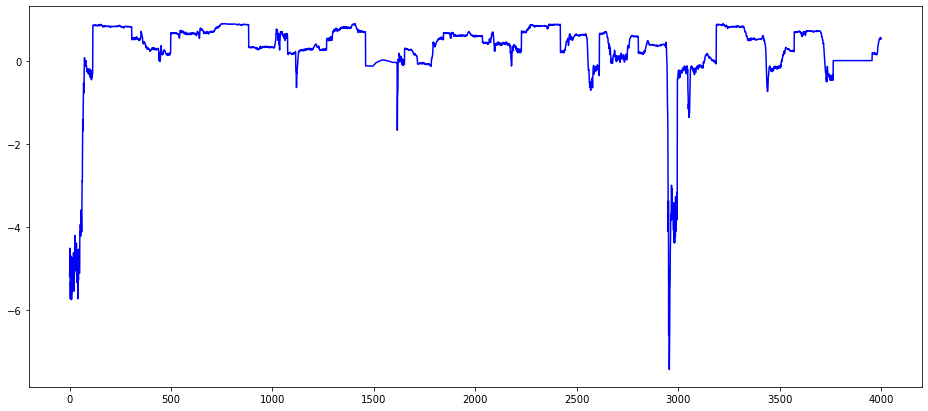

In [30]:
from sklearn.metrics import r2_score

r2l_list_test = []
for i in range(4000):
    o_y = np.transpose(test_Y.iloc[i,:].to_numpy().reshape(1,-1))
    p_y = np.transpose(ypred[i,:].reshape(1,-1))
    r2 = r2_score(o_y, p_y)
    r2l_list_test.append(r2)
fig = plt.figure(figsize = (16, 7))
plt.plot(r2l_list_test, 'b-')

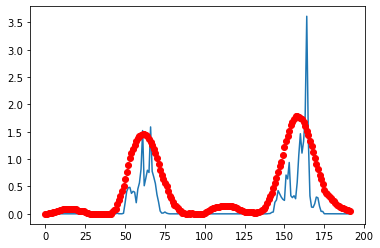

In [33]:
plt.plot(test_Y.to_numpy()[100,])
plt.plot(ypred[100,], 'ro')

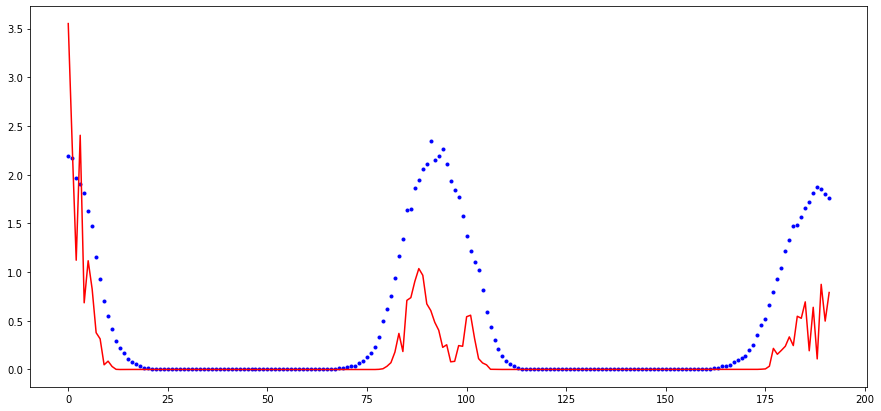

In [13]:
plt.figure(figsize=(15,7))
plt.plot(ypred[192,:], 'b.')
plt.plot(ttest.to_numpy()[192,:],'r-')

In [48]:
from pickle import dump
## pickle the model
dump(regl, open('200lag_10hr','wb'))

In [4]:
## load model
from pickle import load
with open('solar_200lag_10hr', 'rb') as pickcle_file:
    model = load(pickcle_file)

In [5]:
model.refit(ftrain, ttrain)

/home/charles/anaconda3/envs/autosk07/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


AutoSklearnRegressor(delete_output_folder_after_terminate=False,
                     delete_tmp_folder_after_terminate=False,
                     disable_evaluator_output=False, ensemble_memory_limit=5120,
                     ensemble_nbest=25, ensemble_size=50,
                     exclude_estimators=['gaussian_process',
                                         'k_nearest_neighbors',
                                         'decision_tree'],
                     exclude_preprocessors=None, get_smac_object_callback=None,
                     include_estimators...
                     initial_configurations_via_metalearning=0,
                     logging_config=None, max_models_on_disc=50,
                     metadata_directory='solar_meta', metric=None,
                     ml_memory_limit=10092, n_jobs=4, output_folder=None,
                     per_run_time_limit=3600, resampling_strategy='cv',
                     resampling_strategy_arguments={'folds': 5,
                     

In [24]:
from sklearn.utils import resample
n_bootstraps = 50
b_x = []
b_y = []
for _ in range(n_bootstraps):
    sample_X, sample_y = resample(train_X, train_Y, n_samples = 4000)
    b_x.append(sample_X)
    b_y.append(sample_y)

In [25]:
prediction = []

for i, feature in enumerate(b_x):
    model.refit(feature, b_y[i])
    prediction.append(model.predict(test_X))

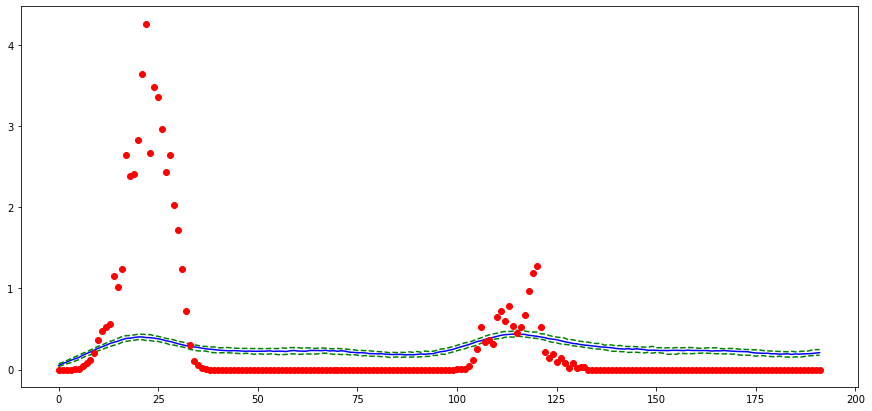

In [29]:
fig = plt.figure(figsize = (15,7))
plt.plot(np.quantile(prediction, 0.5, axis = 0)[1000,:], 'b-')
plt.plot(np.quantile(prediction, 0.9, axis = 0)[1000,:], 'g--')
plt.plot(np.quantile(prediction, 0.1, axis = 0)[1000,:], 'g--')
plt.plot(test_Y.to_numpy()[1000,:], 'ro')

## lag + tsfresh

In [68]:
ftrain.shape, ftrain_tf.shape, ftest.shape, ftest_tf.shape

((4509, 449), (4509, 758), (509, 449), (509, 758))

In [69]:
ftrain_lts = np.concatenate([ftrain.to_numpy(), ftrain_tf.to_numpy()], axis = 1)
ftest_lts = np.concatenate([ftest.to_numpy(), ftest_tf.to_numpy()], axis = 1)

In [14]:
reg_lts = autoreg.AutoSklearnRegressor(time_left_for_this_task=1000,
                                           per_run_time_limit=300,
                                           initial_configurations_via_metalearning=0,
                                           ensemble_size=0, 
                                           ensemble_nbest=0,
                                           ensemble_memory_limit=5120, 
                                           seed=921, ml_memory_limit=6144, 
                                           include_estimators=None,
                                           exclude_estimators='gaussian_process', 
                                           include_preprocessors=None, 
                                           exclude_preprocessors=None, 
                                           resampling_strategy=TimeSeriesSplit,
                                           resampling_strategy_arguments={'folds': 5},
                                           tmp_folder=None, 
                                           output_folder=None, 
                                           delete_tmp_folder_after_terminate=False, 
                                           delete_output_folder_after_terminate=False, 
                                           shared_mode=False, 
                                           n_jobs = 6, 
                                           disable_evaluator_output=False, 
                                           get_smac_object_callback=None, 
                                           smac_scenario_args=None, 
                                           logging_config=None,
                                           metadata_directory=None)


reg_lts.fit(ftrain_lts, ttrain)

NameError: name 'ftrain_lts' is not defined

In [71]:
reg_lts.cv_results_

{'mean_test_score': array([ 0.        ,  0.21177564,  0.        ,  0.        ,  0.        ,
        -0.30709209, -0.02234649, -0.48586259,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        , -0.02585408,
         0.        ,  0.        ,  0.09035615,  0.        ,  0.33210265,
         0.        ,  0.        ,  0.2766813 ,  0.0669718 ,  0.        ,
         0.        ,  0.08851303,  0.00925268,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.29825572,  0.0669718 ,  0.        ,  0.        ,  0.        ,
         0.        ]),
 'mean_fit_time': array([3.00120686e+02, 3.37824309e+01, 2.28317022e-01, 3.00091033e+02,
        1.37731240e+01, 5.53160787e+00, 2.37721062e+00, 4.46084619e+00,
        2.20927954e-01, 3.00126973e+02, 1.21481569e+01, 1.34432335e+01,
        3.00078530e+02, 3.00068238e+02, 3.00122437e+02, 3.00086346e+

In [72]:
print(reg_lts.get_models_with_weights())
print(reg_lts.sprint_statistics())

[(0.46, SimpleRegressionPipeline({'data_preprocessing:categorical_transformer:categorical_encoding:__choice__': 'one_hot_encoding', 'data_preprocessing:categorical_transformer:category_coalescence:__choice__': 'no_coalescense', 'data_preprocessing:numerical_transformer:imputation:strategy': 'median', 'data_preprocessing:numerical_transformer:rescaling:__choice__': 'robust_scaler', 'feature_preprocessor:__choice__': 'feature_agglomeration', 'regressor:__choice__': 'k_nearest_neighbors', 'data_preprocessing:numerical_transformer:rescaling:robust_scaler:q_max': 0.9028878306178143, 'data_preprocessing:numerical_transformer:rescaling:robust_scaler:q_min': 0.10562216348863988, 'feature_preprocessor:feature_agglomeration:affinity': 'manhattan', 'feature_preprocessor:feature_agglomeration:linkage': 'complete', 'feature_preprocessor:feature_agglomeration:n_clusters': 388, 'feature_preprocessor:feature_agglomeration:pooling_func': 'max', 'regressor:k_nearest_neighbors:n_neighbors': 71, 'regresso

In [73]:
reg_lts.refit(ftrain_lts, ttrain)

/home/charles/anaconda3/envs/autoskdev/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


AutoSklearnRegressor(delete_output_folder_after_terminate=False,
                     delete_tmp_folder_after_terminate=False,
                     disable_evaluator_output=False, ensemble_memory_limit=5120,
                     ensemble_nbest=20, ensemble_size=50,
                     exclude_estimators='gaussian_process',
                     exclude_preprocessors=None, get_smac_object_callback=None,
                     include_estimators=None, include_preprocessors=None,
                     initial...
                     logging_config=None, max_models_on_disc=50,
                     metadata_directory=None, metric=None, ml_memory_limit=6144,
                     n_jobs=6, output_folder=None, per_run_time_limit=300,
                     resampling_strategy=<class 'sklearn.model_selection._split.TimeSeriesSplit'>,
                     resampling_strategy_arguments={'folds': 5}, seed=921,
                     shared_mode=False, smac_scenario_args=None,
                     time_le

In [95]:
ypred_lts = reg_lts.predict(ftest_lts[:250,:])
yhat_lts = reg_lts.predict(ftrain_lts)
get_eval(ttest.iloc[:250,:], ypred_lts)
get_eval(ttrain, yhat_lts)

MSE: 606408.0119964308
MAE: 308.69294544392847
r2_score: 0.527026683437762
MSE: 4557.053207206985
MAE: 23.82313953311414
r2_score: 0.9927859197739062


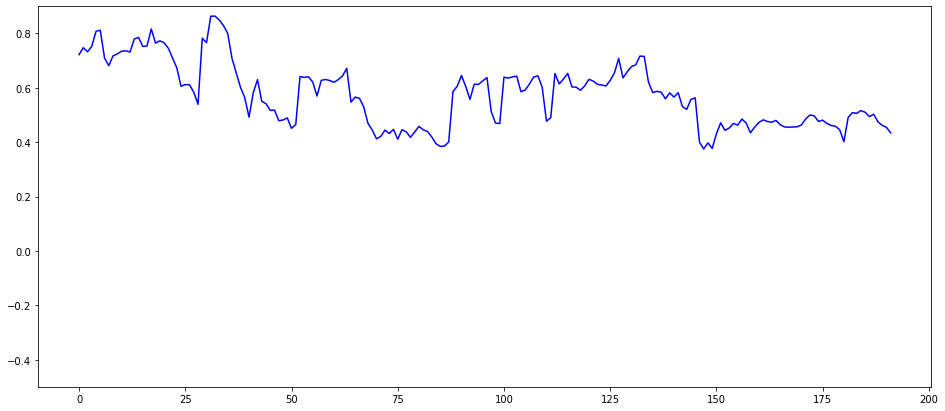

In [76]:
from sklearn.metrics import r2_score

r2c_list_test = []
for i in range(192):
    o_y = np.transpose(ttest.iloc[i,:].to_numpy().reshape(1,-1))
    p_y = np.transpose(ypred_lts[i,:].reshape(1,-1))
    r2 = r2_score(o_y, p_y)
    r2c_list_test.append(r2)
fig = plt.figure(figsize = (16, 7))
plt.ylim(-0.5,0.9)
plt.plot(r2c_list_test, 'b-')

# train:1200, test: 450

## Tsfresh Feature

In [16]:
reg_tf = autoreg.AutoSklearnRegressor(time_left_for_this_task=1000,
                                           per_run_time_limit=100,
                                           initial_configurations_via_metalearning=0,
                                           ensemble_size=0, 
                                           ensemble_nbest=0,
                                           ensemble_memory_limit=4048, 
                                           seed=921, ml_memory_limit=5120, 
                                           include_estimators=None,
                                           exclude_estimators='gaussian_process', 
                                           include_preprocessors=None, 
                                           exclude_preprocessors=None, 
                                           resampling_strategy='cv',
                                           resampling_strategy_arguments={'folds':5},
                                           tmp_folder=None, 
                                           output_folder=None, 
                                           delete_tmp_folder_after_terminate=False, 
                                           delete_output_folder_after_terminate=False, 
                                           shared_mode=False, 
                                           n_jobs = 6, 
                                           disable_evaluator_output=False, 
                                           get_smac_object_callback=None, 
                                           smac_scenario_args=None, 
                                           logging_config=None,
                                           metadata_directory=None)


reg_tf.fit(ftrain_tf, ttrain)

NameError: name 'ftrain_tf' is not defined

In [ ]:
print(reg_tf.get_models_with_weights())
print(reg_tf.sprint_statistics())

In [ ]:
reg_tf.refit(ftrain_tf, ttrain)

In [ ]:
ypred_tf = reg_tf.predict(ftest_tf)
yhat_tf = reg_tf.predict(ftrain_tf)
get_eval(ttest, ypred_tf)
get_eval(ttrain, yhat_tf)

In [ ]:
plt.figure(figsize = (15,7))
plt.plot(ypred_tf[192,:],'g-')
plt.plot(ttest.to_numpy()[192,:], 'ro')

## Lag Feature

In [ ]:
from sklearn.model_selection import TimeSeriesSplit

reg = autoreg.AutoSklearnRegressor(time_left_for_this_task=1000,
                                           per_run_time_limit=100,
                                           initial_configurations_via_metalearning=0,
                                           ensemble_size=50, 
                                           ensemble_nbest=20,
                                           ensemble_memory_limit=4048, 
                                           seed=921, ml_memory_limit=4096, 
                                           include_estimators=None,
                                           exclude_estimators='gaussian_process', 
                                           include_preprocessors=None, 
                                           exclude_preprocessors=None, 
                                           resampling_strategy='cv',
                                           resampling_strategy_arguments={'folds':5},
                                           tmp_folder=None, 
                                           output_folder=None, 
                                           delete_tmp_folder_after_terminate=False, 
                                           delete_output_folder_after_terminate=False, 
                                           shared_mode=False, 
                                           n_jobs = 6, 
                                           disable_evaluator_output=False, 
                                           get_smac_object_callback=None, 
                                           smac_scenario_args=None, 
                                           logging_config=None,
                                           metadata_directory=None)


reg.fit(ftrain, ttrain)

In [ ]:
print(reg.get_models_with_weights())
print(reg.sprint_statistics())

In [ ]:
reg.refit(ftrain, ttrain)

In [ ]:
ypred = reg.predict(ftest)
yhat = reg.predict(ftrain)
get_eval(ttest, ypred)
get_eval(ttrain, yhat)

In [ ]:
plt.figure(figsize = (15,7))
plt.plot(ypred[192,:],'g-')
plt.plot(ttest.to_numpy()[192,:], 'ro')

## Lag + tsFresh Features

In [ ]:
ftrain_lts = np.concatenate([ftrain.to_numpy(), ftrain_tf.to_numpy()], axis = 1)
ftest_lts = np.concatenate([ftest.to_numpy(), ftest_tf.to_numpy()], axis = 1)

In [15]:
reg_lts = autoreg.AutoSklearnRegressor(time_left_for_this_task=1000,
                                           per_run_time_limit=100,
                                           initial_configurations_via_metalearning=0,
                                           ensemble_size=0, 
                                           ensemble_nbest=0,
                                           ensemble_memory_limit=4048, 
                                           seed=921, ml_memory_limit=5120, 
                                           include_estimators=None,
                                           exclude_estimators='gaussian_process', 
                                           include_preprocessors=None, 
                                           exclude_preprocessors=None, 
                                           resampling_strategy='cv',
                                           resampling_strategy_arguments={'folds':5},
                                           tmp_folder=None, 
                                           output_folder=None, 
                                           delete_tmp_folder_after_terminate=False, 
                                           delete_output_folder_after_terminate=False, 
                                           shared_mode=False, 
                                           n_jobs = 6, 
                                           disable_evaluator_output=False, 
                                           get_smac_object_callback=None, 
                                           smac_scenario_args=None, 
                                           logging_config=None,
                                           metadata_directory=None)


reg_lts.fit(ftrain_lts, ttrain)

NameError: name 'ftrain_lts' is not defined

In [ ]:
print(reg_lts.get_models_with_weights())
print(reg_lts.sprint_statistics())

In [ ]:
reg_lts.refit(ftrain_lts, ttrain)

In [ ]:
ypred_lts = reg_lts.predict(ftest_lts)
yhat_lts = reg_lts.predict(ftrain_lts)
get_eval(ttest, ypred_lts)
get_eval(ttrain, yhat_lts)

In [ ]:
plt.figure(figsize = (15,7))
plt.plot(ypred_lts[280,:],'g-')
plt.plot(ttest.to_numpy()[280,:], 'ro')

In [ ]:
from sklearn.utils import resample
n_bootstraps = 50
b_x = []
b_y = []
#for _ in range(n_bootstraps):
#    sample_X, sample_y = resample(ftrain, ttrain)
#    b_x.append(sample_X)
#    b_y.append(sample_y)

In [ ]:
prediction = []

#for i, feature in enumerate(b_x):
#    reg.refit(feature, b_y[i])
#    prediction.append(reg.predict(ftest))

In [ ]:
fig = plt.figure(figsize = (15,7))
plt.plot(np.quantile(prediction, 0.8, axis = 0)[100,:], 'g--')
plt.plot(np.quantile(prediction, 0.1, axis = 0)[100,:], 'g--')
plt.plot(np.quantile(prediction, 0.5, axis = 0)[100,:], 'b-')
plt.plot(ttest.to_numpy()[100,:], 'ro')

In [ ]:
reg.refit(ftrain, ttrain)

In [ ]:
ypred_t = reg.predict(ftest)

In [ ]:
yhat = reg.predict(ftrain)

In [ ]:
get_eval(ttest.to_numpy(), np.quantile(prediction, 0.5, axis = 0))
get_eval(ttrain.to_numpy(), yhat)

In [ ]:
fig = plt.figure(figsize = (15,7))
plt.plot(ypred_t[100,:],'g--')
plt.plot(ttest.to_numpy()[100,:], 'ro') 

fig = plt.figure(figsize = (15,7))
plt.plot(yhat[100,:],'g--')
plt.plot(ttrain.to_numpy()[100,:], 'ro') 

In [ ]:
from sklearn.metrics import r2_score

r2_list_test = []
for i in range(ftest.shape[0]):
    o_y = np.transpose(ttest.iloc[i,:].to_numpy().reshape(1,-1))
    p_y = np.transpose(ypred_t[i,:].reshape(1,-1))
    r2 = r2_score(o_y, p_y)
    r2_list_test.append(r2)

r2_list_train = []
for i in range(ftrain.shape[0]):
    o_y = np.transpose(ttrain.iloc[i,:].to_numpy().reshape(1,-1))
    p_y = np.transpose(yhat[i,:].reshape(1,-1))
    r2 = r2_score(o_y, p_y)
    r2_list_train.append(r2)

In [ ]:
fig = plt.figure(figsize = (16, 7))
plt.ylim(0.7)
plt.plot(r2_list_test)

### Condidence interval: Bootstrap

In [ ]:
from sklearn.utils import resample
n_bootstraps = 50
bootstrap_X = []
bootstrap_y = []


In [ ]:
prediction = []

for i, feature in enumerate(bootstrap_X):
    reg.refit(feature, bootstrap_y[i])
    prediction.append(reg.predict(ftest))

In [ ]:
fig = plt.figure(figsize = (15,7))
plt.plot(np.quantile(prediction, 0.5, axis = 0)[1,:], 'b-')
plt.plot(np.quantile(prediction, 0.95, axis = 0)[1,:], 'g--')
plt.plot(np.quantile(prediction, 0.05, axis = 0)[1,:], 'g--')
plt.plot(ttest.to_numpy()[1,:], 'ro')

### Confidence interval: Static

In [ ]:
reg.get_models_with_weights()

In [ ]:
# %load functions.py
import seaborn as sns
import pandas as pd
import numpy as np
from pandas import datetime

def plot_conf_static(val_y, val_y_pred, test_y, test_y_pred, n, alpha):
    # confidence interval
    q_m = np.quantile(val_y - val_y_pred, 0.5, axis = 0)
    q_u = np.quantile(val_y - val_y_pred, 1 - alpha/2, axis = 0) - q_m
    q_l = q_m - np.quantile(val_y - val_y_pred, alpha/2, axis = 0) 
        
    
    ypred_t_ub = test_y_pred  + q_u
    ypred_t_lb = test_y_pred  - q_l
    # plot
    fig = plt.figure(figsize=(16,7))
    font = {'family' : 'Lucida Grande',
            'weight' : 'bold',
            'size'   : 15}
    plt.rc('font', **font)
    plt.style.use('seaborn')
    plt.plot(test_y_pred[n, :].reshape(-1,1), 'gx-',label='Prediction')
    plt.plot(ypred_t_ub[n, :].reshape(-1,1), 'g--', label='{} % upper bond'.format((1-alpha/2)*100))
    plt.plot(ypred_t_lb[n, :].reshape(-1,1), 'g--', label='{} % lower bond'.format((alpha/2)*100))
    plt.plot(test_y.iloc[n, :].to_numpy().reshape(-1,1), 'ro', label='Ground truth')
    #plt.fill(np.concatenate([xx, xx[::-1]]),
    #         np.concatenate([y_upper, y_lower[::-1]]),
    #         alpha=.5, fc='b', ec='None', label='90% prediction interval')
    plt.xlabel('hours', **font)
    plt.ylabel('KWh', **font)
    plt.legend(loc='upper left', fontsize = 15)
    plt.show()


def verf_ci_static(alpha, val_y, ypred, ttest, ypred_t):
    
    q_m = np.quantile(val_y - ypred, 0.5, axis = 0)
    q_u = np.quantile(val_y - ypred, 1 - alpha/2, axis = 0) - q_m
    q_l = q_m - np.quantile(val_y - ypred, alpha/2, axis = 0) 
    
    precentage_list = []
    err_count = 0

    for i in range(ttest.shape[0]):
        count = 0
        for j in range(ttest.shape[1]):
            if ttest.iloc[i,j] <=  (ypred_t[i,j] + q_u[j]) and ttest.iloc[i,j] >= (ypred_t[i,j] - q_l[j]):
                count += 1
        if count/ttest.shape[1] < (1- alpha):
            err_count += 1
        precentage_list.append(count/ttest.shape[1])

    print("out_of_bound_pecentage", err_count/ttest.shape[0])
    fig = plt.figure(figsize = (16,7))
    font = {'family' : 'Lucida Grande',
            'weight' : 'bold',
            'size'   : 15}
    plt.rc('font', **font)
    plt.style.use('seaborn')
    plt.xlabel('Number of testing sets', **font)
    plt.ylabel('Out_of_bound_error', **font)
    plt.plot(precentage_list)

    
def plot_conf_std_static(val_y, val_y_pred, test_y, test_y_pred, n, ci_term):
    # confidence interval
    if(ci_term == 1.96):
        alpha = 0.05
    elif(ci_term == 1.645):
        alpha = 0.10
    elif(ci_term == 1.28):
        alpha = 0.20
        
    std = np.mean((val_y - val_y_pred)**2)**0.5   
    ypred_t_ub = test_y_pred[n,:]  + std*ci_term
    ypred_t_lb = test_y_pred[n,:]  - std*ci_term
    # plot
    fig = plt.figure(figsize=(16,7))
    font = {'family' : 'Lucida Grande',
            'weight' : 'bold',
            'size'   : 15}
    plt.rc('font', **font)
    plt.style.use('seaborn')
    plt.plot(test_y_pred[n, :].reshape(-1,1), 'gx-',label='Prediction')
    plt.plot(ypred_t_ub.to_numpy().reshape(-1,1), 'g--', label='{} % upper bond'.format((1-alpha/2)*100))
    plt.plot(ypred_t_lb.to_numpy().reshape(-1,1), 'g--', label='{} % lower bond'.format((alpha/2)*100))
    plt.plot(test_y.iloc[n, :].to_numpy().reshape(-1,1), 'ro', label='Ground truth')
    #plt.fill(np.concatenate([xx, xx[::-1]]),
    #         np.concatenate([y_upper, y_lower[::-1]]),
    #         alpha=.5, fc='b', ec='None', label='90% prediction interval')
    plt.xlabel('hours', **font)
    plt.ylabel('KWh', **font)
    plt.legend(loc='upper left', fontsize = 15)
    plt.show()

    
def verf_ci_std_static(ci_term, val_y, ypred, ttest, ypred_t):
    
    # confidence interval
    if(ci_term == 1.96):
        alpha = 0.05
    elif(ci_term == 1.645):
        alpha = 0.10
    elif(ci_term == 1.28):
        alpha = 0.20
    
    std = np.mean((val_y-ypred)**2)**0.5
    
    precentage_list = []
    err_count = 0

    for i in range(ttest.shape[0]):
        count = 0
        for j in range(ttest.shape[1]):
            if ttest.iloc[i,j] <=  (ypred_t[i,j] + std[j] * ci_term) and ttest.iloc[i,j] >= (ypred_t[i,j] - std[j]*ci_term):
                count += 1
        if count/ttest.shape[1] < (1- alpha):
            err_count += 1
        precentage_list.append(count/ttest.shape[1])

    print("out_of_bound_pecentage", err_count/ttest.shape[0])
    fig = plt.figure(figsize = (16,7))
    font = {'family' : 'Lucida Grande',
            'weight' : 'bold',
            'size'   : 15}
    plt.rc('font', **font)
    plt.style.use('seaborn')
    plt.xlabel('Number of testing sets', **font)
    plt.ylabel('Out_of_bound_error', **font)
    plt.plot(precentage_list)


In [ ]:
plot_conf_std_static(ttrain, yhat, ttest, ypred_t, 200,1.96)

In [ ]:
verf_ci_std_static(1.96, ttrain, yhat, ttest.iloc[:800,:], ypred_t[:800,:])

In [ ]:
plot_conf_static(ttrain, yhat, ttest, ypred_t, 1000, 0.05)

In [ ]:
verf_ci_static(0.05, ttrain, yhat, ttest, ypred_t)

### Confidence interval: Dynamically fitting error

In [ ]:
err_reg = autoreg.AutoSklearnRegressor(time_left_for_this_task=1800, 
                                           per_run_time_limit=600, 
                                           initial_configurations_via_metalearning=0,
                                           ensemble_size=20, 
                                           ensemble_nbest=10, 
                                           ensemble_memory_limit=4590, 
                                           seed=1, ml_memory_limit=5096, 
                                           include_estimators= None, 
                                           exclude_estimators=None, 
                                           include_preprocessors=None, 
                                           exclude_preprocessors=None, 
                                           resampling_strategy=KFold,  
                                           resampling_strategy_arguments={'n_splits' : 3},
                                           tmp_folder=None, 
                                           output_folder=None, 
                                           delete_tmp_folder_after_terminate=False, 
                                           delete_output_folder_after_terminate=False, 
                                           shared_mode=False, 
                                           n_jobs = 6, 
                                           disable_evaluator_output=False, 
                                           get_smac_object_callback=None, 
                                           smac_scenario_args=None, 
                                           logging_config=None,
                                           metadata_directory=None)

err_reg.fit(ttrain, (ttrain - yhat)**2)

In [ ]:
print(err_reg.show_models())

In [ ]:
print(err_reg.sprint_statistics())

In [ ]:
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics
from sklearn.ensemble import ExtraTreesRegressor

etr = ExtraTreesRegressor(n_estimators=100)
scores = cross_val_score(etr, val_X, (val_y - yhat)**2, scoring = 'r2', cv=5, n_jobs = 6)
print("Cross-validated scores:", scores)

In [ ]:
plot_conf_dynamic(perror, ttest, ypred, 0, 1.645)

In [ ]:
plot_conf_static(ttest, ypred, ttest, ypred, 0, 1.645)